### ABSTRACT

--> Add description of our rationale to classify the images vs labels
--> Compare the 3 class_modes (sparse, binary & categorical)
--> Evaluate Transfer learning and then Fine-Tuning

Thinking process followed


### Import dependencies

In [1]:
!python --version

Python 3.10.12


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
from keras import models, layers

import keras.preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten

from PIL import Image
import os
import matplotlib.pyplot as plt

In [4]:
#!pip3 install tensorflow
import tensorflow
print(tensorflow.__version__)

2.15.0


In [5]:
#!pip3 install keras
import keras
print(keras.__version__)

2.15.0


In [6]:
np.random.seed(8)
tf.random.set_seed(8)

### Extract / Transform / Load the data

In [7]:
Train_df=pd.read_csv('/content/drive/MyDrive/crop-disease/Train.csv')
Test_df=pd.read_csv('/content/drive/MyDrive/crop-disease/Test.csv')

Let’s check what the data looks like

In [8]:
Train_df.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


In [9]:
Test_df.head()

,Image_id
0,id_00exusbkgzw1b.jpg
1,id_03dqinf6w0znv.jpg
2,id_046yl0cxn3ybz.jpg
3,id_04athdtx2abyg.jpg
4,id_062aauf9e9jk0.jpg


In [10]:
images_path='/content/drive/MyDrive/crop-disease/images/'

Merge Train_data column 'Image_id' with the image path

Then do same for the Test_data

In [11]:
''' ATTENTION
AFTER FIRST RUN OF THE BELOW CODE,
DO NOT RE-RUN THIS CELL UNLESS YOU RUN THE "pd.read_csv" FIRST
(otherwise the 'for loop' will create an incorrect 'Image_id')
'''
Train_df['Image_id']= [images_path+i for i in Train_df.Image_id]
Train_df['Label']= Train_df['Label'].astype(str)
Train_df

,Image_id,Label
0,/content/drive/MyDrive/crop-disease/images/id_...,1
1,/content/drive/MyDrive/crop-disease/images/id_...,0
2,/content/drive/MyDrive/crop-disease/images/id_...,0
3,/content/drive/MyDrive/crop-disease/images/id_...,1
4,/content/drive/MyDrive/crop-disease/images/id_...,1
...,...,...
1614,/content/drive/MyDrive/crop-disease/images/id_...,0
1615,/content/drive/MyDrive/crop-disease/images/id_...,1
1616,/content/drive/MyDrive/crop-disease/images/id_...,0
1617,/content/drive/MyDrive/crop-disease/images/id_...,0


In [12]:
type(Train_df['Image_id'][0])
Train_df['Image_id'][0]

'/content/drive/MyDrive/crop-disease/images/id_02amazy34fgh2.jpg'

In [13]:
type(Train_df['Label'][10])

str

In [14]:
''' ATTENTION
AFTER FIRST RUN OF THE BELOW CODE,
DO NOT RE-RUN THIS CELL UNLESS YOU RUN THE "pd.read_csv" FIRST
(otherwise the 'for loop' will create an incorrect 'Image_id')
'''
Test_df['Image_id']= [images_path+i for i in Test_df.Image_id]
Test_df

,Image_id
0,/content/drive/MyDrive/crop-disease/images/id_...
1,/content/drive/MyDrive/crop-disease/images/id_...
2,/content/drive/MyDrive/crop-disease/images/id_...
3,/content/drive/MyDrive/crop-disease/images/id_...
4,/content/drive/MyDrive/crop-disease/images/id_...
...,...
1075,/content/drive/MyDrive/crop-disease/images/id_...
1076,/content/drive/MyDrive/crop-disease/images/id_...
1077,/content/drive/MyDrive/crop-disease/images/id_...
1078,/content/drive/MyDrive/crop-disease/images/id_...


### Preprocess the data for modelling

For this project, we would be using the **ImageDataGenerator** to augment the images and **.flow_from_dataframe** to load the data. After rescaling all the images to a particular size we then augment the images.

**flow_from_dataframe** will be very useful to us. It checks the path available on the dataframe and then automatically search for the image in train directory. Then it make the desired preprocessing steps available in ImageDataGenerator (mitigates memory usage)

Note: It is not compulsory to augment image data, we only augment image data to improve the performance and the outcome of the model by forming new and different examples to the train and validation datasets

When you use the **.flow from_dataframe data loader**, pass in the csv file, the image_id as the x column ,the target as the y column, the target_size of the images, the class_mode, subset,seed and batch _size. There are other arguments you can pass in depending on what you want to do.

The 'class_mode' can be: sparse (multi-label, 1D), binary (0 or 1, 1D) or categorical (multi-class, one-hot encoded 2D)

In [15]:
#train data generation
TRAIN_GEN = ImageDataGenerator(
    rescale=1./255, #normalisation of images
    #Augmentation
    rotation_range=40,
    shear_range=0.2,
    zoom_range =0.2,
    fill_mode='nearest',
    validation_split=0.2,
    horizontal_flip= True)

myClassModes = ["sparse", "binary", "categorical"]
#mySubset = ["training", "validation"]
#myClasses = ["0_Not-Affected", "1_Affected"]

def gen_ds_per_ClassMode(class_mode, subset):

  gen_data = TRAIN_GEN.flow_from_dataframe(Train_df,
                                        x_col='Image_id',
                                        y_col='Label',
                                        target_size=(224,224),
                                        #classes = myClasses,
                                        class_mode=class_mode,
                                        subset=subset,
                                        seed=123,
                                        batch_size=32)
  return gen_data

train_ds_sparse = gen_ds_per_ClassMode('sparse', 'training')
train_ds_binary = gen_ds_per_ClassMode('binary', 'training')
train_ds_categorical = gen_ds_per_ClassMode('categorical', 'training')
validation_ds_sparse = gen_ds_per_ClassMode('sparse', 'validation')
validation_ds_binary = gen_ds_per_ClassMode('binary', 'validation')
validation_ds_categorical = gen_ds_per_ClassMode('categorical', 'validation')

#test data generation
TEST_GEN=ImageDataGenerator(rescale=1./255)
testdata = TEST_GEN.flow_from_dataframe(Test_df,
                                        x_col='Image_id',
                                        y_col=None,
                                        target_size=(224,224),
                                        class_mode=None,
                                        seed=123,
                                        shuffle=False,
                                        batch_size=32)

Found 1296 validated image filenames belonging to 2 classes.
Found 1296 validated image filenames belonging to 2 classes.
Found 1296 validated image filenames belonging to 2 classes.
Found 323 validated image filenames belonging to 2 classes.
Found 323 validated image filenames belonging to 2 classes.
Found 323 validated image filenames belonging to 2 classes.
Found 1080 validated image filenames.


For the test data loader we put the **y_col as None** because that is what we are predicting.

Note: **.flow_from_dataframe** returns a _DataFrameIterator_ yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.


### Visualize the data

Here are the first 6 images from the training dataset:

In [19]:
# Displaying the data (image; label) as tensors
count=0
for image_batch, label_batch in train_ds_binary:
#     print(label_batch)
    print(image_batch[0])
    break
#     count+=1
#     if count>2:
#         break

[[[0.15370452 0.13409668 0.16154766]
  [0.17098087 0.14693272 0.17615983]
  [0.19084981 0.15136556 0.18679397]
  ...
  [0.23123823 0.22922532 0.2494146 ]
  [0.17671008 0.16693011 0.19338873]
  [0.16556442 0.14944889 0.17689987]]

 [[0.18280016 0.16319232 0.1906433 ]
  [0.21399139 0.1880065  0.2180083 ]
  [0.25856042 0.21830145 0.2541172 ]
  ...
  [0.2323188  0.2280997  0.2517779 ]
  [0.1689631  0.15840843 0.1852544 ]
  [0.16711383 0.15022358 0.17767456]]

 [[0.18391001 0.1711563  0.20123778]
  [0.21402325 0.19361988 0.22308129]
  [0.24212517 0.20877643 0.2422034 ]
  ...
  [0.21667571 0.2116819  0.23574744]
  [0.10477019 0.09344082 0.12067413]
  [0.1544148  0.13674986 0.16420084]]

 ...

 [[0.50872153 0.5176156  0.5857176 ]
  [0.4991151  0.50735825 0.5757857 ]
  [0.49113113 0.49872333 0.5674763 ]
  ...
  [0.16166282 0.10892254 0.13637352]
  [0.16290665 0.10934171 0.137265  ]
  [0.12606663 0.0734878  0.10086395]]

 [[0.5137255  0.5254902  0.5921569 ]
  [0.5100954  0.5218601  0.5885268 ]


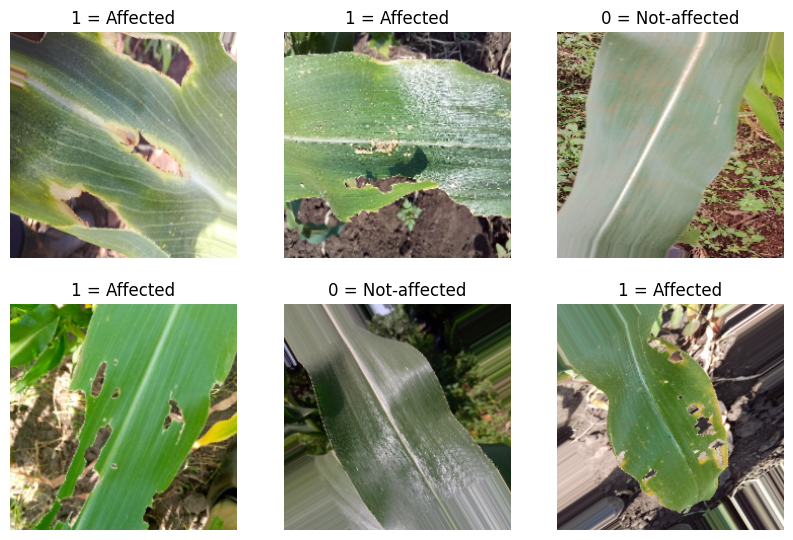

In [25]:
Crop_state = ["0 = Not-affected", "1 = Affected"]
plt.figure(figsize=(10, 10))
#for _ in range(len(traindata.filenames)):
for _ in range(6):
     ax = plt.subplot(3, 3, _ + 1)
     image, label = train_ds_binary.next()
     # display the image from the iterator
     label_name=label[0]       #new_dict[label[0]] # note you are only showing the first image of the batch
     plt.title(Crop_state[int(label_name)])
     plt.imshow(image[0])
     plt.axis("off")

In [26]:
len(train_ds_binary)

41

In [27]:
# 'Train_df' is split into "training" and "validation sets"
#let's check the number of batches (of 32 images each)
training_ratio = 0.8
print("training samples: ",train_ds_binary.samples,"\n")
print("training batches: ", np.floor(len(Train_df) * training_ratio / train_ds_binary.batch_size)+1)
#traindata.samples

training samples:  1296 

training batches:  41.0


In [28]:
# the validation set also:
validation_ratio = 0.2
#len(Train_df) / traindata.batch_size*validation_ratio
print("validation samples: ",validation_ds_binary.samples,"\n")
print("validation batches: ", np.floor(len(Train_df) * validation_ratio / validation_ds_binary.batch_size)+1)

validation samples:  323 

validation batches:  11.0


### BUILD MODEL BY "TRANSFER LEARNING"

Let’s build our model:

using a pre-trained model is what we call Transfer Learning. Transfer Learning is a method in machine learning where a model developed for a task is reused as the starting point for a model on another similar task. Transfer learning is computationally efficient and helps achieve better results using a small amount of data. For this project, we are using a pre-trained model to classify the plant image which is infected or uninfected.

Refer: https://keras.io/guides/transfer_learning/

**Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.** (our case)

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

We have several pre-trained models for image classification. Examples are **VGG16, VGG19, InceptionV3, ResNet50, ResNetV2, etc**. These pre-trained models have been trained on millions of images making it easier to perform better on our data.

Let’s import the pre-trained model we are using.

In [16]:
'''Model was already called through tensorflow.keras'''
from keras.applications.vgg19 import VGG19

We would be using VGG19 as our pretrained model. VGG19 is a variant of the VGG model which consists of 19 layers (16 convolution layers, 3 fully connected layers, 5 MaxPool layers, and 1 SoftMax layer).

Now, we are done importing the pre-trained model. We would not be loading the output layer for the model, because the **VGG19** model was initially trained with the ImageNet database that contains a million images **of 1000 classes**. Since we are working on a binary image classification we, therefore, **freeze** the initial **output layers that have 1000 classes** and **add our output layer**. We freeze the output layer **by putting False to the include_top argument**. VGG19 takes the input shape of the images 224x224 size.

In [17]:
model = VGG19(include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 2s 0us/step


In the below code we set our trainable argument to false because we don’t want the VGG19 model’s weight to interfere with our current data so we freeze the weight of the pre-trained model.

In [18]:
for layer in model.layers:
    layer.trainable=False
pretrained_part = Flatten()(model.layers[-1].output)

Let's add our output layer:

In [19]:
class_ = Dense(256, activation='relu')(pretrained_part)
out_ = Dense(1, activation='sigmoid')(class_) # for 'sparse'
model_sparse = Model(inputs = model.inputs, outputs = out_) # for 'sparse' or 'binary' (1D)
#out_binary = Dense(1, activation='sigmoid')(class_) # for 'binary'
model_binary = Model(inputs = model.inputs, outputs = out_) # for 'binary'
out_categ = Dense(2, activation='sigmoid')(class_) # for class_mode='categorical' (2D)
model_categ = Model(inputs = model.inputs, outputs = out_categ) # for class_mode='categorical' (2D)

Let’s compile the model using Adam as the optimizer, loss as binary_crossentropy, because it’s a binary image classification and metrics as Accuracy score

In [20]:
model_sparse.compile(optimizer='Adam',loss='binary_crossentropy',metrics=[('Accuracy')])
model_binary.compile(optimizer='Adam',loss='binary_crossentropy',metrics=[('Accuracy')])
model_categ.compile(optimizer='Adam',loss='binary_crossentropy',metrics=[('Accuracy')])

In [21]:
# CHECKING MODEL SUMMARY
#plt.figure(figsize=(10,5))
#plt.subplot(131)
model_sparse.summary() # (try to visualize tables side by side?)
#plt.subplot(132)
model_binary.summary()
#plt.subplot(133)
model_categ.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

The above image is the output when you run the model.summary() code, it brings out the layers of the model. We can also see that there are 26,447,682 total parameters for the model, of which 6,423,298 are trainable parameters. The remaining 20,024,384 are non-trainable parameters, which are the weights we froze.

Let’s now train the model!!!

To train our model we pass in the train data, validation data, epochs, and steps_per_epochs this is the number of unique samples of your dataset divided by the batch size and the verbose. The verbose will show the output of the model while training.

In [23]:
history_sparse = model_sparse.fit(train_ds_sparse,
            validation_data=validation_ds_sparse,
            epochs=30,
            steps_per_epoch=10,
            verbose=2)

Epoch 1/30
10/10 - 284s - loss: 2.7161 - Accuracy: 0.5592 - val_loss: 0.4004 - val_Accuracy: 0.8050 - 284s/epoch - 28s/step
Epoch 2/30
10/10 - 98s - loss: 0.5274 - Accuracy: 0.7434 - val_loss: 0.3378 - val_Accuracy: 0.8390 - 98s/epoch - 10s/step
Epoch 3/30
10/10 - 80s - loss: 0.3242 - Accuracy: 0.8717 - val_loss: 0.3162 - val_Accuracy: 0.8576 - 80s/epoch - 8s/step
Epoch 4/30
10/10 - 65s - loss: 0.2628 - Accuracy: 0.8813 - val_loss: 0.1891 - val_Accuracy: 0.9195 - 65s/epoch - 6s/step
Epoch 5/30
10/10 - 45s - loss: 0.1495 - Accuracy: 0.9375 - val_loss: 0.1509 - val_Accuracy: 0.9474 - 45s/epoch - 5s/step
Epoch 6/30
10/10 - 36s - loss: 0.1383 - Accuracy: 0.9438 - val_loss: 0.1500 - val_Accuracy: 0.9659 - 36s/epoch - 4s/step
Epoch 7/30
10/10 - 31s - loss: 0.1309 - Accuracy: 0.9638 - val_loss: 0.1344 - val_Accuracy: 0.9505 - 31s/epoch - 3s/step
Epoch 8/30
10/10 - 26s - loss: 0.1336 - Accuracy: 0.9500 - val_loss: 0.1647 - val_Accuracy: 0.9164 - 26s/epoch - 3s/step
Epoch 9/30
10/10 - 19s - los

In [24]:
history_binary = model_binary.fit(train_ds_binary,
            validation_data=validation_ds_binary,
            epochs=30,
            steps_per_epoch=10,
            verbose=2)

Epoch 1/30
10/10 - 13s - loss: 0.2142 - Accuracy: 0.9219 - val_loss: 0.1409 - val_Accuracy: 0.9567 - 13s/epoch - 1s/step
Epoch 2/30
10/10 - 11s - loss: 0.0877 - Accuracy: 0.9671 - val_loss: 0.1465 - val_Accuracy: 0.9505 - 11s/epoch - 1s/step
Epoch 3/30
10/10 - 12s - loss: 0.1254 - Accuracy: 0.9500 - val_loss: 0.1095 - val_Accuracy: 0.9505 - 12s/epoch - 1s/step
Epoch 4/30
10/10 - 12s - loss: 0.0877 - Accuracy: 0.9594 - val_loss: 0.0735 - val_Accuracy: 0.9752 - 12s/epoch - 1s/step
Epoch 5/30
10/10 - 12s - loss: 0.0818 - Accuracy: 0.9781 - val_loss: 0.1263 - val_Accuracy: 0.9536 - 12s/epoch - 1s/step
Epoch 6/30
10/10 - 12s - loss: 0.0925 - Accuracy: 0.9750 - val_loss: 0.0932 - val_Accuracy: 0.9721 - 12s/epoch - 1s/step
Epoch 7/30
10/10 - 12s - loss: 0.0293 - Accuracy: 0.9969 - val_loss: 0.0794 - val_Accuracy: 0.9752 - 12s/epoch - 1s/step
Epoch 8/30
10/10 - 12s - loss: 0.0501 - Accuracy: 0.9844 - val_loss: 0.0644 - val_Accuracy: 0.9814 - 12s/epoch - 1s/step
Epoch 9/30
10/10 - 12s - loss: 0

In [25]:
history_categ = model_categ.fit(train_ds_categorical,
            validation_data=validation_ds_categorical,
            epochs=30,
            steps_per_epoch=10,
            verbose=2)

Epoch 1/30
10/10 - 13s - loss: 0.4526 - Accuracy: 0.8281 - val_loss: 0.2501 - val_Accuracy: 0.8885 - 13s/epoch - 1s/step
Epoch 2/30
10/10 - 11s - loss: 0.1305 - Accuracy: 0.9563 - val_loss: 0.1351 - val_Accuracy: 0.9474 - 11s/epoch - 1s/step
Epoch 3/30
10/10 - 12s - loss: 0.1006 - Accuracy: 0.9594 - val_loss: 0.0928 - val_Accuracy: 0.9814 - 12s/epoch - 1s/step
Epoch 4/30
10/10 - 12s - loss: 0.0920 - Accuracy: 0.9625 - val_loss: 0.0901 - val_Accuracy: 0.9721 - 12s/epoch - 1s/step
Epoch 5/30
10/10 - 12s - loss: 0.0561 - Accuracy: 0.9844 - val_loss: 0.0869 - val_Accuracy: 0.9783 - 12s/epoch - 1s/step
Epoch 6/30
10/10 - 11s - loss: 0.0848 - Accuracy: 0.9719 - val_loss: 0.1200 - val_Accuracy: 0.9505 - 11s/epoch - 1s/step
Epoch 7/30
10/10 - 11s - loss: 0.0510 - Accuracy: 0.9875 - val_loss: 0.0908 - val_Accuracy: 0.9628 - 11s/epoch - 1s/step
Epoch 8/30
10/10 - 11s - loss: 0.0678 - Accuracy: 0.9868 - val_loss: 0.0820 - val_Accuracy: 0.9783 - 11s/epoch - 1s/step
Epoch 9/30
10/10 - 11s - loss: 0

The accuracy of our model is quite high.

###Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the VGG19 base model as a fixed feature extractor.

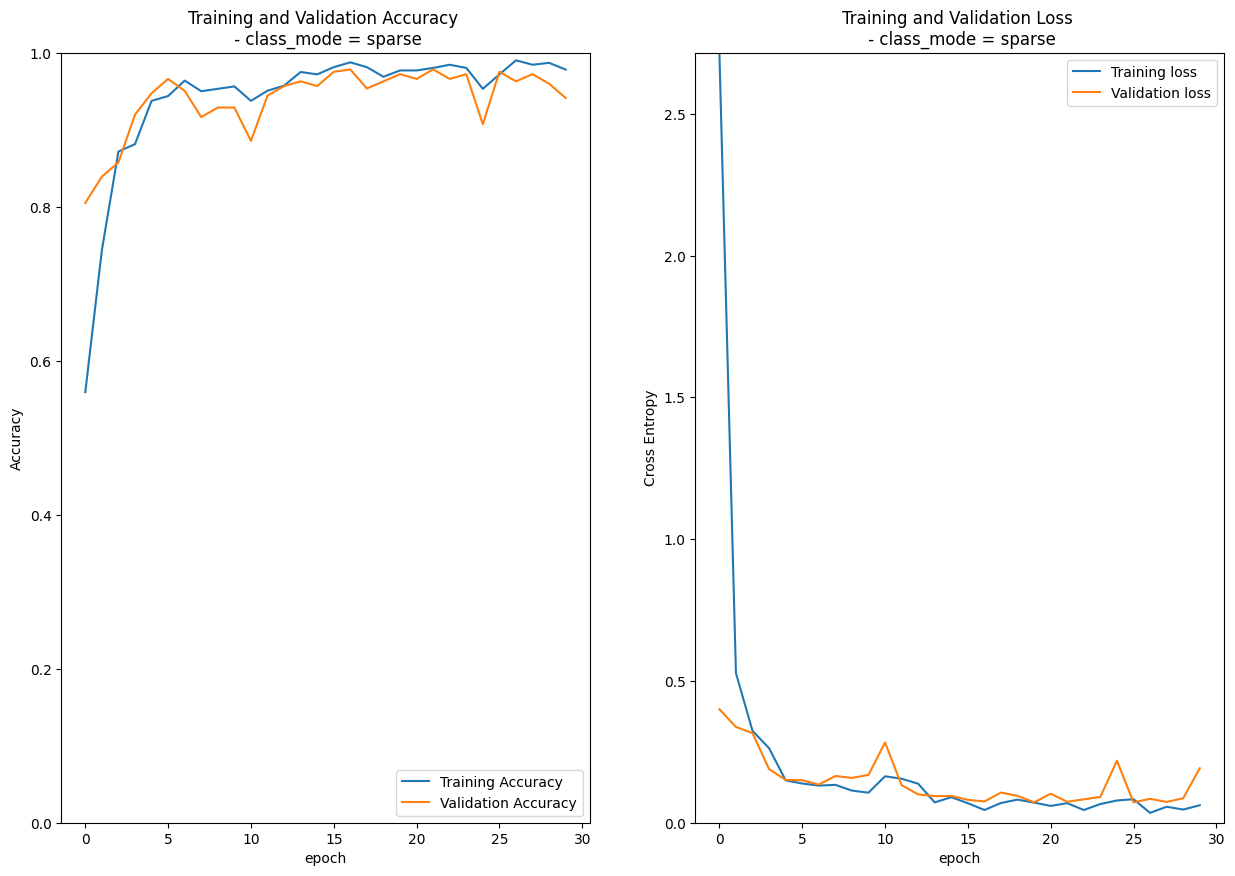

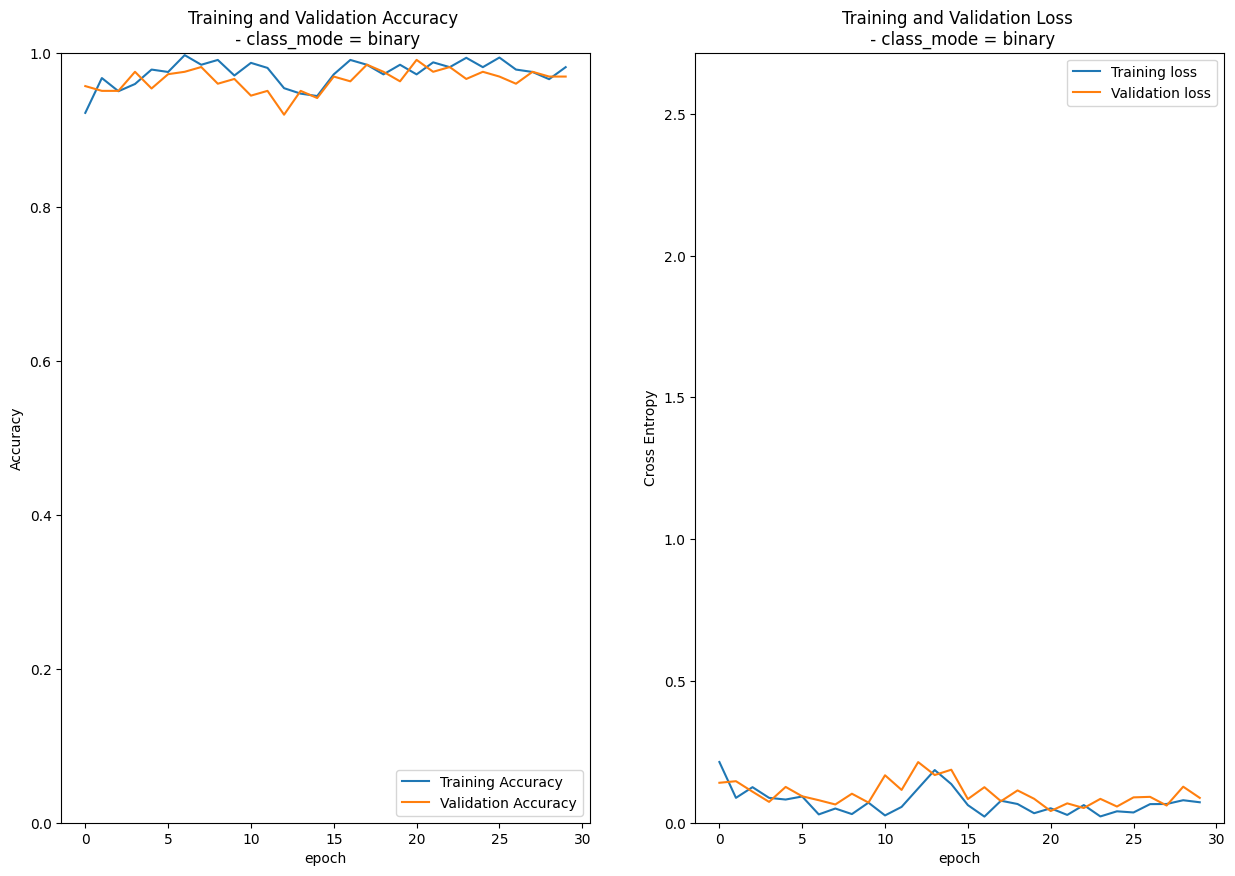

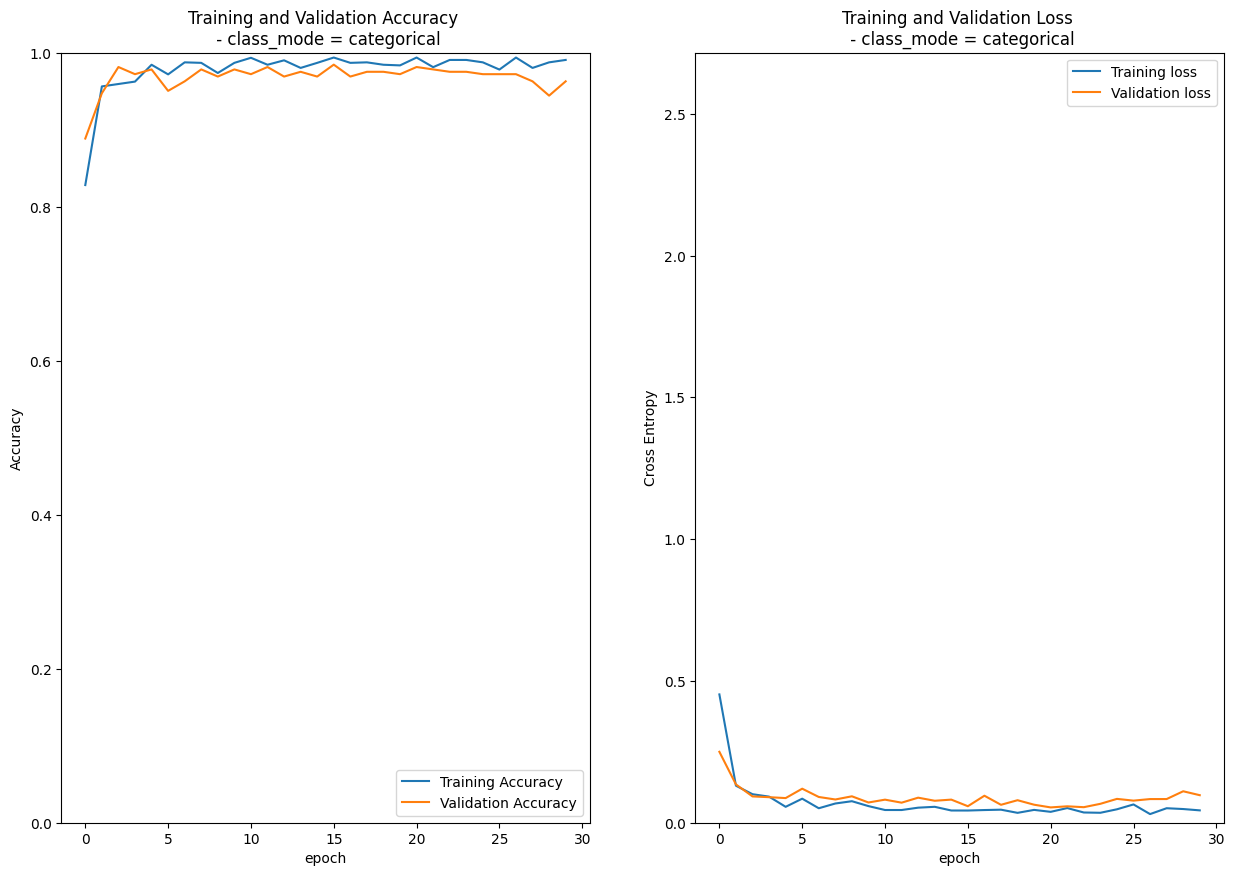

In [31]:
 # acc_sparse = history_sparse.history['Accuracy']
  # val_acc_sparse = history_sparse.history['val_Accuracy']
  # loss_sparse = history_sparse.history['loss']
  # val_loss_sparse = history_sparse.history['val_loss']

params = ['Accuracy', 'loss']
val_params = ['val_Accuracy', 'val_loss']
myHist = [history_sparse, history_binary, history_categ]
y_lbl = ['Accuracy', 'Cross Entropy']

#def plotMyResults(params, val_params, myHist, y_lbl):

# def myHistFunc(myHist, p):
#   var1 = history_sparse.history[p]
#   var2 = history_sparse.history[val_params[v]]

mymax1_List = [max(myHist[i].history[val_params[1]]) for i in range(3)] # determine the 'max ylim' for future plotting
mymax1 = max(mymax_List[:])
mymax2_List = [max(myHist[i].history[params[1]]) for i in range(3)]
mymax2 = max(mymax2_List[:])
mymax = max(mymax1, mymax2)

for m in range(3):
    title_acc = f'Training and Validation Accuracy \n - class_mode = {myClassModes[m]}'
    title_loss = f'Training and Validation Loss \n - class_mode = {myClassModes[m]}'
    title = [title_acc, title_loss]

    v = 0
    plt.figure(figsize=(15, 10))
    plt.figure(1+m)
    for p in params:
        var1 = myHist[m].history[p]
        var2 = myHist[m].history[val_params[v]]
        plt.subplot(1, 2, 1+v)
        plt.plot(var1, label=f'Training {p}')
        plt.plot(var2, label=f'Validation {p}')
        plt.ylabel(y_lbl[v])
        if v == 0 :
          plt.legend(loc='lower right')
          plt.ylim([0,1])
          #plt.ylim([min(plt.ylim()),1])
        else :
          plt.legend(loc='upper right')
          plt.ylim([0,mymax])   #was max(plt.ylim())
        plt.title(title[v])
        plt.xlabel('epoch')
        #plt.show()
        v = v + 1

#print('newline \n')
  # plt.subplot(1, 2, 2)
  # plt.plot(loss_sparse, label='Training Loss')
  # plt.plot(val_loss_sparse, label='Validation Loss')
  # plt.legend(loc='upper right')
  # plt.ylabel('Cross Entropy')
  # #plt.ylim([0,1.0])
  # plt.title(title_loss)
  # plt.xlabel('epoch')
  # #plt.show()

Summary:
3 variants of the transfer learning VGG19 model were used: sparse, binary and categorical

By far, the 'Binary class_mode' takes the prize as it has shown the best accuracy and learning results.

Let’s now run the predict function by using each variant of the model to classify the images in the test dataset

In [32]:
predictions_sparse=model_sparse.predict(testdata)
predictions_binary=model_binary.predict(testdata)
predictions_categ=model_categ.predict(testdata)
predictions_sparse
predictions_binary
predictions_categ

34/34 [==============================] - 9s 268ms/step


array([[9.9705732e-01, 1.6305665e-03],
       [9.9179780e-01, 6.0464502e-03],
       [2.7212588e-08, 1.0000000e+00],
       ...,
       [9.9957711e-01, 5.2794046e-04],
       [4.7861165e-03, 9.9839836e-01],
       [2.7787031e-05, 9.9999034e-01]], dtype=float32)

Note:
in the original "Medium" code, the class_mode was set to 'Categorical'. If you did so and printed out the predictions, you'd get two values which are the probability of each label being the actual value. This can be quite confusing; to avoid this, the argmax() function from the Numpy library is used. The argmax function prints the index of the maximum value. If the first value is maximum it prints out 0, if the second value is maximum it prints out 1.
In our case above, class_mode is set to 'Sparse' and outputs a 1D array, so the probabilities are directly given (Rounding those would make output as 0 or 1)

In [33]:
'''' TO BE UPDATED as argmax() needs more than 1 output argument'''
pred_categ_labels=[ np.argmax(i) for i in predictions_categ] # OK for categorical only
pred_sparse_labels = np.round(predictions_sparse.flatten(), 0) # OK for binary or sparse
pred_binary_labels = np.round(predictions_binary.flatten(), 0) # OK for binary or sparse

print(pred_sparse_labels[:6])
print(pred_binary_labels[:6])
print(pred_categ_labels[:6])

[0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0.]
[0, 0, 1, 0, 0, 0]


All 3 variants of the model showed same prediction for the first 6 images.
Still, as mentioned before, the 'binary' model variant was the best and therefore shall be used for the model fine-tuning part.

In [ ]:
'''SAVING TRANSFER LEARNING MODELS'''

#### Saving the "transfer learning" model variants (sparse, binary and categorical)

We append the model to the list of models as a new version

In [34]:
#To 'SavedModel' format
models_path = "/content/drive/MyDrive/crop-disease/SparsBinCat models_v1.2c/SavedModel_Sp"
model_version=max([int(i) for i in os.listdir(models_path) + [0]])+1
model_sparse.save(f"{models_path}/{model_version}")

In [35]:
models_path = "/content/drive/MyDrive/crop-disease/SparsBinCat models_v1.2c/SavedModel_Bin"
model_version=max([int(i) for i in os.listdir(models_path) + [0]])+1
model_binary.save(f"{models_path}/{model_version}")

In [36]:
models_path = "/content/drive/MyDrive/crop-disease/SparsBinCat models_v1.2c/SavedModel_Cat"
model_version=max([int(i) for i in os.listdir(models_path) + [0]])+1
model_categ.save(f"{models_path}/{model_version}")

In [37]:
# h5 format
model_sparse.save("/content/drive/MyDrive/crop-disease/SparsBinCat models_v1.2c/HDF5/myVGG19_sparse1.h5")
model_binary.save("/content/drive/MyDrive/crop-disease/SparsBinCat models_v1.2c/HDF5/myVGG19_binary1.h5")
model_categ.save("/content/drive/MyDrive/crop-disease/SparsBinCat models_v1.2c/HDF5/myVGG19_categ1.h5")
#INFO:tensorflow:Assets written to: ../models/3/assets

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
# Keras format
model_sparse.save("/content/drive/MyDrive/crop-disease/SparsBinCat models_v1.2c/Keras/myVGG19_sparse1.keras")
model_binary.save("/content/drive/MyDrive/crop-disease/SparsBinCat models_v1.2c/Keras/myVGG19_binary1.keras")
model_categ.save("/content/drive/MyDrive/crop-disease/SparsBinCat models_v1.2c/Keras/myVGG19_categ1.keras")

### Fine-tuning on "BINARY" model

**Transfer Learning** and **Fine-Tuning** are crucial techniques in deep learning. They allow for the transfer of knowledge gained from solving one problem to a related problem, reducing the amount of data and computation required for training1.
**Transfer learning** is when a model developed for one task is reused to work on a second task.

**Fine-tuning** is one approach to transfer learning where you change the model output to fit the new task and train only the output model. While transfer learning involves freezing the pre-trained model’s weights and only training the new layers, fine-tuning takes it a step further by allowing the pre-trained layers to be updated

A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

In [39]:
'''Fine-tuning'''
#call again the "base" VGG19 model trained on the crop images dataset.
#Only this time, implement fine-tuning on it

'Fine-tuning'

In [40]:
# New second stage: unfreeze VGG19 layers and continue training.
# Unfreeze the base model by:
# model.trainable = True
model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account

# optimizer could be specified with: opt = Adam(learning_rate=0.001, beta_1=0.9)
# opt = keras.optimizers.Adam(
#     learning_rate=0.0001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-08,
#     amsgrad=False,
#     weight_decay=None,
#     clipnorm=None,
#     clipvalue=None,
#     global_clipnorm=None,
#     use_ema=False,
#     ema_momentum=0.99,
#     ema_overwrite_frequency=None,
#     name="Adam"
# )
#m = keras.metrics.SparseCategoricalAccuracy()
opt=keras.optimizers.Adam(1e-5)
''' Now let's compile the fine-tuning on same models with VERY LOW learning rate'''
# model_sparse.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

FT_model_binary = model_binary #create a new name for the fine-tuned model
FT_model_binary.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# #full_model_categ = Sequential(layers=model_categ.layers)
# model_categ.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [41]:
# CHECKING MODEL SUMMARY (FT vs transfer learning version)
FT_model_binary.summary()
model_binary.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [42]:
#fine-tuned model fitting
history_binary_fullmod = FT_model_binary.fit(train_ds_binary,
            validation_data=validation_ds_binary,
            epochs=30,
            steps_per_epoch=10,
            verbose=2)

Epoch 1/30
10/10 - 23s - loss: 0.1144 - accuracy: 0.9605 - val_loss: 0.1938 - val_accuracy: 0.9412 - 23s/epoch - 2s/step
Epoch 2/30
10/10 - 13s - loss: 0.1386 - accuracy: 0.9563 - val_loss: 0.1730 - val_accuracy: 0.9505 - 13s/epoch - 1s/step
Epoch 3/30
10/10 - 12s - loss: 0.0248 - accuracy: 0.9875 - val_loss: 0.0398 - val_accuracy: 0.9876 - 12s/epoch - 1s/step
Epoch 4/30
10/10 - 12s - loss: 0.0211 - accuracy: 0.9969 - val_loss: 0.0545 - val_accuracy: 0.9783 - 12s/epoch - 1s/step
Epoch 5/30
10/10 - 12s - loss: 0.0577 - accuracy: 0.9844 - val_loss: 0.1172 - val_accuracy: 0.9659 - 12s/epoch - 1s/step
Epoch 6/30
10/10 - 12s - loss: 0.0217 - accuracy: 0.9937 - val_loss: 0.0660 - val_accuracy: 0.9845 - 12s/epoch - 1s/step
Epoch 7/30
10/10 - 12s - loss: 0.0328 - accuracy: 0.9875 - val_loss: 0.2217 - val_accuracy: 0.9536 - 12s/epoch - 1s/step
Epoch 8/30
10/10 - 12s - loss: 0.0879 - accuracy: 0.9719 - val_loss: 0.0540 - val_accuracy: 0.9845 - 12s/epoch - 1s/step
Epoch 9/30
10/10 - 12s - loss: 0

In [ ]:
# history_binary_fullmod = model_binary.fit(train_ds_binary,
#             validation_data=validation_ds_binary,
#             epochs=15,
#             steps_per_epoch=10,
#             verbose=2)

In [ ]:
# history_categ_fullmod = model_categ.fit(train_ds_categorical,
#             validation_data=validation_ds_categorical,
#             epochs=15,
#             steps_per_epoch=10,
#             verbose=2)

### Fine-tuned model Learning curves

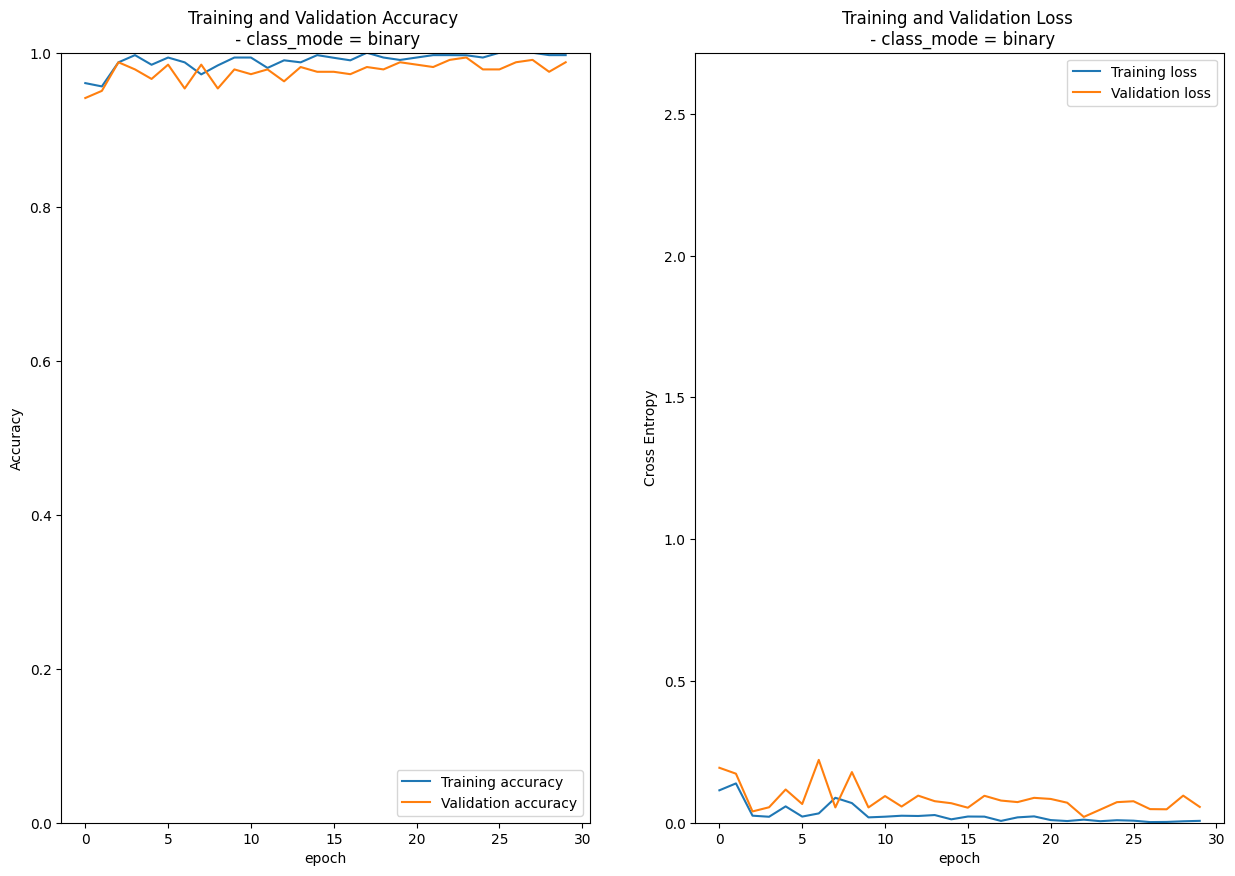

In [44]:
  # acc_sparse = history_sparse.history['Accuracy']
  # val_acc_sparse = history_sparse.history['val_Accuracy']
  # loss_sparse = history_sparse.history['loss']
  # val_loss_sparse = history_sparse.history['val_loss']

params = ['accuracy', 'loss']
val_params = ['val_accuracy', 'val_loss']
myHist_fullmod = ['history_sparse_fullmod', history_binary_fullmod, 'history_categ_fullmod']
y_lbl = ['Accuracy', 'Cross Entropy']

#def plotMyResults(params, val_params, myHist, y_lbl):

# def myHistFunc(myHist, p):
#   var1 = history_sparse.history[p]
#   var2 = history_sparse.history[val_params[v]]

#plt.figure(figsize=(10, 10))
#for _ in range(len(traindata.filenames)):

#for m in range(3):

m=1 # for 'binary' class_mode
title_acc = f'Training and Validation Accuracy \n - class_mode = {myClassModes[m]}'
title_loss = f'Training and Validation Loss \n - class_mode = {myClassModes[m]}'
title = [title_acc, title_loss]
v = 0
plt.figure(figsize=(15, 10))
#plt.figure(1+m)
for p in params:
    var1f = myHist_fullmod[m].history[p]
    var2f = myHist_fullmod[m].history[val_params[v]]
    #plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1+v)
    plt.plot(var1f, label=f'Training {p}')
    plt.plot(var2f, label=f'Validation {p}')
    plt.ylabel(y_lbl[v])
    if v == 0 :
      plt.legend(loc='lower right')
      plt.ylim([0,1])
      #plt.ylim([min(plt.ylim()),1])
    else :
      plt.legend(loc='upper right')
      plt.ylim([0,mymax])  # max(plt.ylim())])
    plt.title(title[v])
    plt.xlabel('epoch')
    #plt.show()
    v = v + 1

#print('newline \n')
  # plt.subplot(1, 2, 2)
  # plt.plot(loss_sparse, label='Training Loss')
  # plt.plot(val_loss_sparse, label='Validation Loss')
  # plt.legend(loc='upper right')
  # plt.ylabel('Cross Entropy')
  # #plt.ylim([0,1.0])
  # plt.title(title_loss)
  # plt.xlabel('epoch')
  # #plt.show()

Summary:
Compared to Transfer Learning results, the fine-tuning of the binary variant model showed even better results than before:

1/ the training and validation accuracy are now even closer to 1

2/ the Loss function is now even lower than before and more consistent in its values: it started from 0.13 (was 0.22) to reach its minimum at 0.03 (was 0.07)

Let's now check the predictions using the binary fine-tuned model:

In [45]:
# predictions_sparse_fullmod=model_sparse.predict(testdata)
predictions_binary_fullmod=model_binary.predict(testdata)
# predictions_categ_fullmod=model_categ.predict(testdata)
# predictions_sparse_fullmod
predictions_binary_fullmod
# predictions_categ_fullmod

34/34 [==============================] - 9s 262ms/step


array([[1.0499470e-05],
       [7.9317197e-06],
       [1.0000000e+00],
       ...,
       [3.2343023e-06],
       [9.9999988e-01],
       [1.0000000e+00]], dtype=float32)

This result illustrates the previous summary and observations on the fine-tuned binary model, showing the output probabilities.

Now we need to convert the prediction probability to target labels:

In [46]:
'''' TO BE UPDATED as argmax() needs more than 1 output argument'''
# pred_categ_labels_fullmod = [ np.argmax(i) for i in predictions_categ_fullmod] # OK for categorical only
#pred_sparse_labels_fullmod = np.round(predictions_sparse_fullmod.flatten(), 0) # OK for binary or sparse
pred_binary_labels_fullmod = np.round(predictions_binary_fullmod.flatten(), 0) # OK for binary or sparse

# print(pred_sparse_labels_fullmod[:6])
print(pred_binary_labels_fullmod[:6])
# print(pred_categ_labels_fullmod[:6])

[0. 0. 1. 0. 0. 0.]


In [ ]:
''' INTEREST IN BLURRING AN IMAGE OR FINDING A BLURRED ONE AND SUBMITTING IT TO THE MODELS PREDICTION ??? '''
# TO BLUR AN IMAGE


### SAVE MODEL & WRITE LABELS IN CSV

In [47]:
!dir

drive  sample_data


#### Saving the "fine-tuning" model (binary variant)

In [48]:
#To 'SavedModel' format
models_path = "/content/drive/MyDrive/crop-disease/Fine-Tuning"
model_version=max([int(i) for i in os.listdir(models_path) + [0]])+1
FT_model_binary.save(f"{models_path}/{model_version}")

In [49]:
# h5 format
FT_model_binary.save("/content/drive/MyDrive/crop-disease/Fine-Tuning/my-FT-VGG19_binary.h5")
#INFO:tensorflow:Assets written to: ../models/3/assets

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
# keras format
FT_model_binary.save("/content/drive/MyDrive/crop-disease/Fine-Tuning/my-FT-VGG19_binary.keras")

In [51]:

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/crop-disease/Fine-Tuning/my-FT-VGG19_binary.keras")


In [52]:
predictions=reconstructed_model.predict(testdata)
FT_pred_labels = np.round(predictions.flatten(), 0) # OK for binary or sparse

34/34 [==============================] - 9s 259ms/step


#### Let's generate the submission csv file with the Test images IDs and their predicted Labels

In [54]:
submit=pd.read_csv('/content/drive/MyDrive/crop-disease/SampleSubmission.csv')
submission = pd.DataFrame({ 'Image_id':submit.Image_id.values, 'Label': FT_pred_labels})
submission.to_csv("/content/drive/MyDrive/crop-disease/my_submission.csv", index=False) # Creates csv in the 'crop-disease' folder

When this code is done executing , a new csv file called my_submission csv will be created on the given path.

Finally, we have a model that can predict if a plant is infected or uninfected.

Further interesting investigations we thought of is to use OpenCV API to generate more images and augment the dataset.

Then, check how the fine-tuned model performs and try and understand the results.

### Generate requirements.txt, session_info and sys.modules dictionary

In [57]:
!pip install session-info

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.5 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=7b6668b9cce1ff70aafca2249b4feaadeb34a950f0de36b14785ff317a21e998
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [62]:
import session_info
print(session_info.show)

<function show at 0x7853d11a9900>


In [63]:
# You can get a list of all imported modules by doing:
import sys
print(sys.modules.keys())

dict_keys(['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '_abc', 'abc', 'io', '__main__', 'types', 'enum', '_sre', 'sre_constants', 'sre_parse', 'sre_compile', '_collections_abc', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', '_functools', 'functools', '_locale', 'copyreg', 're', 'warnings', '_stat', 'stat', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_distutils_hack', 'importlib._bootstrap', 'importlib._bootstrap_external', 'importlib', 'importlib._abc', 'contextlib', 'importlib.util', 'importlib.machinery', 'google', 'google.cloud', 'mpl_toolkits', 'sphinxcontrib', 'sitecustomize', 'site', 'runpy', 'ipykernel._version', '_json', 'json.scanner', 'json.decoder', 'json.encoder', 'json', 'errno', 'signal', '_weakrefset', 'threa

In [64]:
!pip3 freeze > requirements.txt

## Other approaches (suggestion for future investigations)

Ref: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751


### Classifiers on top of deep convolutional neural networks

As mentioned before, models for image classification that result from a transfer learning approach based on pre-trained convolutional neural networks are usually composed of two parts:

Convolutional base, which performs feature extraction.
Classifier, which classifies the input image based on the features extracted by the convolutional base.
Since in this section we focus on the classifier part, we must start by saying that different approaches can be followed to build the classifier. Some of the most popular are:

1. **Fully-connected layers**. For image classification problems, the standard approach is to use a stack of fully-connected layers followed by a softmax activated layer (Krizhevsky et al. 2012, Simonyan & Zisserman 2014, Zeiler & Fergus 2014). The softmax layer outputs the probability distribution over each possible class label and then we just need to classify the image according to the most probable class.

2. **Global average pooling**. A different approach, based on global average pooling, is proposed by Lin et al. (2013). In this approach, instead of adding fully connected layers on top of the convolutional base, we add a global average pooling layer and feed its output directly into the softmax activated layer. Lin et al. (2013) provides a detailed discussion on the advantages and disadvantages of this approach.

3. **Linear support vector machines**. Linear support vector machines (SVM) is another possible approach. According to Tang (2013), we can improve classification accuracy by training a linear SVM classifier on the features extracted by the convolutional base. Further details about the advantages and disadvantages of the SVM approach can be found in the paper.